# Deep Learning Spring 2025: Finetuning with LoRA Final Model

Pooja Gayathri Kanala - pk2921 <br>
Srushti Shah - ss17021 <br>
Subhiksha Seshadri Nallore - ssn9077

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 167.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19207 sha256=c3de3bc52389b17959bc74806ebe544a0c117ee78043d2b61cef9c5c387e2cde
  Stored in directory: /teamspace/studios/this_studio/.cache/pip/wheels/5c/d8/c0/46899f8be7a75a2ffd197a23c8797700ea858b9b34819fbf9e
Successfully built nvidia-ml-py3


In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

## Load Tokenizer and Preprocess Data

In [ ]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# PEFT Config
peft_config = LoraConfig(
    r=8,                    # LoRA rank
    lora_alpha=10,          # scaling factor
    lora_dropout=0.1,       # dropout on adapter output
    bias='none',            # no bias adapters
    task_type="SEQ_CLS",
    target_modules=['query', 'value'],       # inject into these projections
    layers_to_transform=[9, 10],         # apply to these 3 layers
    inference_mode=True,
    init_lora_weights=True,
    modules_to_save=['classifier', 'score']
)

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 741,124 || all params: 125,389,832 || trainable%: 0.5911


## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [ ]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
        learning_rate=2e-4,
        num_train_epochs=3,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        warmup_ratio=0.1,
        weight_decay=0.01,
        logging_steps=100,
        eval_steps=500,
        save_steps=500,
        eval_strategy="steps",
        save_strategy="steps",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

### Start Training

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy
500,0.164400,0.214506,0.940625
1000,0.152000,0.234643,0.928125
1500,0.147300,0.228849,0.928125
2000,0.149000,0.231408,0.929688
2500,0.143300,0.246995,0.932813
3000,0.147500,0.254971,0.929688
3500,0.136600,0.228704,0.931250
4000,0.157000,0.236202,0.932813
4500,0.150200,0.223013,0.942187
5000,0.158200,0.219669,0.939063


## Evaluate Finetuned Model

### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:01<00:00, 78.59it/s]

Evaluation Metric: {'accuracy': 0.9421875}


### Run Inference on unlabelled dataset

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"Submission4.csv"), index=False)
print("Inference complete. Predictions saved to Submission4.csv")

100%|██████████| 1000/1000 [00:11<00:00, 85.10it/s]

Inference complete. Predictions saved to Submission4.csv


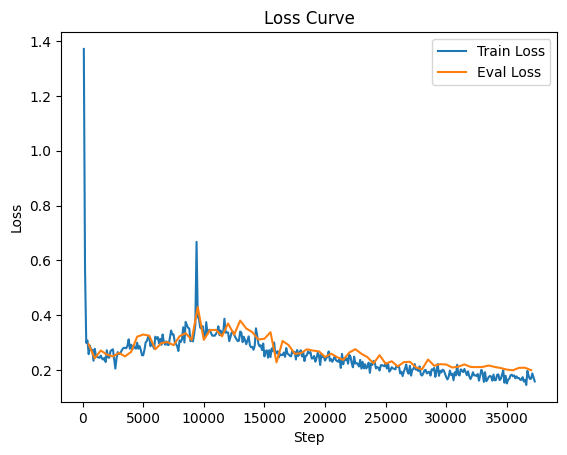

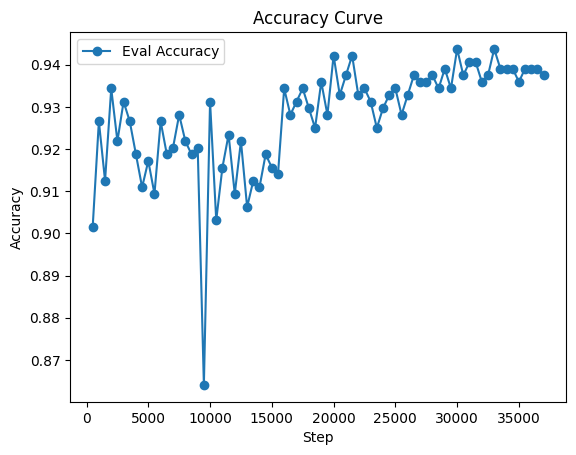

In [ ]:
import matplotlib.pyplot as plt

# use your Trainer instance, not the model
trainer = peft_lora_finetuning_trainer

# pull out the history
history = trainer.state.log_history

# split into train vs eval entries
train_entries = [h for h in history if "loss" in h and "eval_loss" not in h]
eval_entries  = [h for h in history if "eval_loss" in h]

train_steps    = [e["step"] for e in train_entries]
train_loss     = [e["loss"] for e in train_entries]

eval_steps     = [e["step"] for e in eval_entries]
eval_loss      = [e["eval_loss"] for e in eval_entries]
eval_accuracy  = [e["eval_accuracy"] for e in eval_entries]

# Plot Loss
plt.figure()
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss,   label="Eval Loss")
plt.xlabel("Step"); plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(eval_steps, eval_accuracy, marker="o", label="Eval Accuracy")
plt.xlabel("Step"); plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()
